In [2]:
import nilearn
from nilearn import plotting, masking
from nilearn import datasets, image
from nilearn.maskers import NiftiLabelsMasker
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import zipfile, os, multiprocessing, itertools
import scipy.stats as stat

In [2]:
stat_event_map = {
"pe1":	"wait",
"pe2":	"go_45_prep",
"pe3":	"go_45_prep 1st deriv",
"pe4":	"go_99_prep",
"pe5":	"go_99_prep 1st deriv",
"pe6":	"go_153_prep",
"pe7":	"go_153_prep 1st deriv",
"pe8":	"go_207_prep",
"pe9":	"go_207_prep 1st deriv",
"pe10":	"nogo_45_prep",
"pe11":	"nogo_45_prep 1st deriv",
"pe12":	"nogo_99_prep",
"pe13":	"nogo_99_prep 1st deriv",
"pe14":	"nogo_153_prep",
"pe15":	"nogo_153_prep 1st deriv",
"pe16":	"nogo_207_prep",
"pe17":	"nogo_207_prep 1st deriv",
"pe18":	"movement_45",
"pe19":	"movement_45 1st deriv",
"pe20":	"movement_99",
"pe21":	"movement_99 1st deriv",
"pe22":	"movement_153",
"pe23":	"movement_153 1st deriv",
"pe24":	"movement_207",
"pe25":	"movement_207 1st deriv",
"pe26":	"non_movement_45",
"pe27":	"non_movement_45 1st deriv",
"pe28":	"non_movement_99",
"pe29":	"non_movement_99 1st deriv",
"pe30":	"non_movement_153",
"pe31":	"non_movement_153 1st deriv",
"pe32":	"non_movement_207",
"pe33":	"non_movement_207 1st deriv"
}

event_stat_map = dict([(value, key) for key, value in stat_event_map.items()])


# Atlases and ROI masks

In [3]:
dataset_juelich = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }

# dataset_msdl = datasets.fetch_atlas_msdl()
# masks = {"motor": "Motor", 
#          "parietal": "L Par",
#          "vis": "Vis",
#          "cerebellum": "Cereb"       
        # }
# atlas_filename = dataset_ho['maps']

# Function to extract ROI fMRI stignals in an array
1. Path: Path of the stat map nii.gz file
2. Conditions: condition label appended to the path based on event stat map
3. Region: Specifies ROI mask (region to atlas label map from atlas above)
4. dataset_juelich: Juelich dataset

In [14]:
def extract_roi_signals_juelich(path, conditions, region, masks, dataset_juelich):
    #determine mask image from juelich atlas
    mask_image = image.new_img_like(dataset_juelich.maps, image.get_data(dataset_juelich.maps) == np.where(np.array(dataset_juelich.labels) == masks[region])[0][0])

    #Apply the mask to data for all (33) conditions where each condition corresponds to stat map (output of fsl feat)
    fmri_masked = [
        masking.apply_mask(image.load_img(path+f'{event_stat_map[condition]}.nii.gz'), 
        mask_img = image.resample_to_img(mask_image, image.load_img(path+f'{event_stat_map[condition]}.nii.gz'), 
        interpolation='nearest')
        )
        for condition in conditions  
    ]
    return fmri_masked

Extract all paths for straight and rotated blocks. 

Extracting for 23 participnats because the 24th participant seems to not have one rotated block

In [5]:
sub_straight_paths = np.ravel([[
        f'feat/sub-{str(sub).zfill(2)}/ses-S1/straight_run-{str(run).zfill(2)}.vma.event-related.fmriprep.feat/stats/' 
        for run in range(1, 10, 2)
    ] for sub in range(1, 24)
])

sub_rotate_paths = np.ravel([[
        f'feat/sub-{str(sub).zfill(2)}/ses-S1/rotate_run-{str(run).zfill(2)}.vma.event-related.fmriprep.feat/stats/' 
        for run in range(2, 12, 2)
    ] for sub in range(1, 24)
])

# Compute correlations for all subjects
1. paths: image paths extracted above
2. region: ROI region from juelich atlas (through masks map above)
3. nsub: 23 subjects

In [6]:
def extract_corr_all_sub(paths, region = 'motor', nsub = 23):
    #parallelize extracting roi signals. This is the main bottleneck in computation since it requires reading and writing
    pool = multiprocessing.Pool()
    signal_all_sub = pool.starmap(
            extract_roi_signals_juelich,
            zip(paths, 
            itertools.repeat(list(event_stat_map.keys())), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
        )

    #compute correlations for each subject between conditions. 
    #[1::2] allows for alternating conditions so that we get correlations of beta weights from actual events and not their derivatives. 
    #Skipping the first one (as [1::2]) skips the 'wait' periods
    corr_maps = np.array([
            [
                [
                    stat.pearsonr(x, y)[0] for x in signal_all_sub[sub_block][1::2] 
                ]
            for y in signal_all_sub[sub_block][1::2]
            ]
        for sub_block in range(len(signal_all_sub))
    ])


    # print(signal_all_sub.shape)
    return corr_maps.reshape(nsub, 5, corr_maps.shape[1], corr_maps.shape[2])


In [7]:
#Extract correlations for all subjects in dictionaries

straight_corr_dict = {}
for key in masks.keys():
    straight_corr_dict[key] = extract_corr_all_sub(sub_straight_paths, region=key)
    print('Mask done: ', key)

rotate_corr_dict = {}
for key in masks.keys():
    rotate_corr_dict[key] = extract_corr_all_sub(sub_rotate_paths, region=key)
    print('Mask done: ', key)

Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  somatosensory
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  somatosensory


In [8]:
#Dictionaries to dataframes for easy plotting and stats

temp_df = []
for region in masks.keys():
    corr_df = pd.DataFrame({
        'subject': np.repeat(np.arange(23), 5*16*16),
        'block': np.tile(np.repeat(np.arange(5), 16*16), 23),
        'cond 1': np.tile(np.repeat(list(event_stat_map.keys())[1::2], 16), 5*23),
        'cond 2': np.tile(list(event_stat_map.keys())[1::2], 16*5*23),
        'correlations': np.ravel(straight_corr_dict[region])
    })
    corr_df['region'] = region
    corr_df['type'] = 'straight'
    temp_df.append(corr_df)

for region in masks.keys():
    corr_df = pd.DataFrame({
        'subject': np.repeat(np.arange(23), 5*16*16),
        'block': np.tile(np.repeat(np.arange(5), 16*16), 23),
        'cond 1': np.tile(np.repeat(list(event_stat_map.keys())[1::2], 16), 5*23),
        'cond 2': np.tile(list(event_stat_map.keys())[1::2], 16*5*23),
        'correlations': np.ravel(rotate_corr_dict[region])
    })
    corr_df['region'] = region
    corr_df['type'] = 'rotate'
    temp_df.append(corr_df)


corr_df = pd.concat(temp_df)

In [18]:
corr_df.to_csv('mvpa_outputs/event_correlations.csv')

Plotting

/work/pi_rcowell_umass_edu/tsavalia/scratch/miniconda3/envs/vma_fmri/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_3230959/1189078344.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


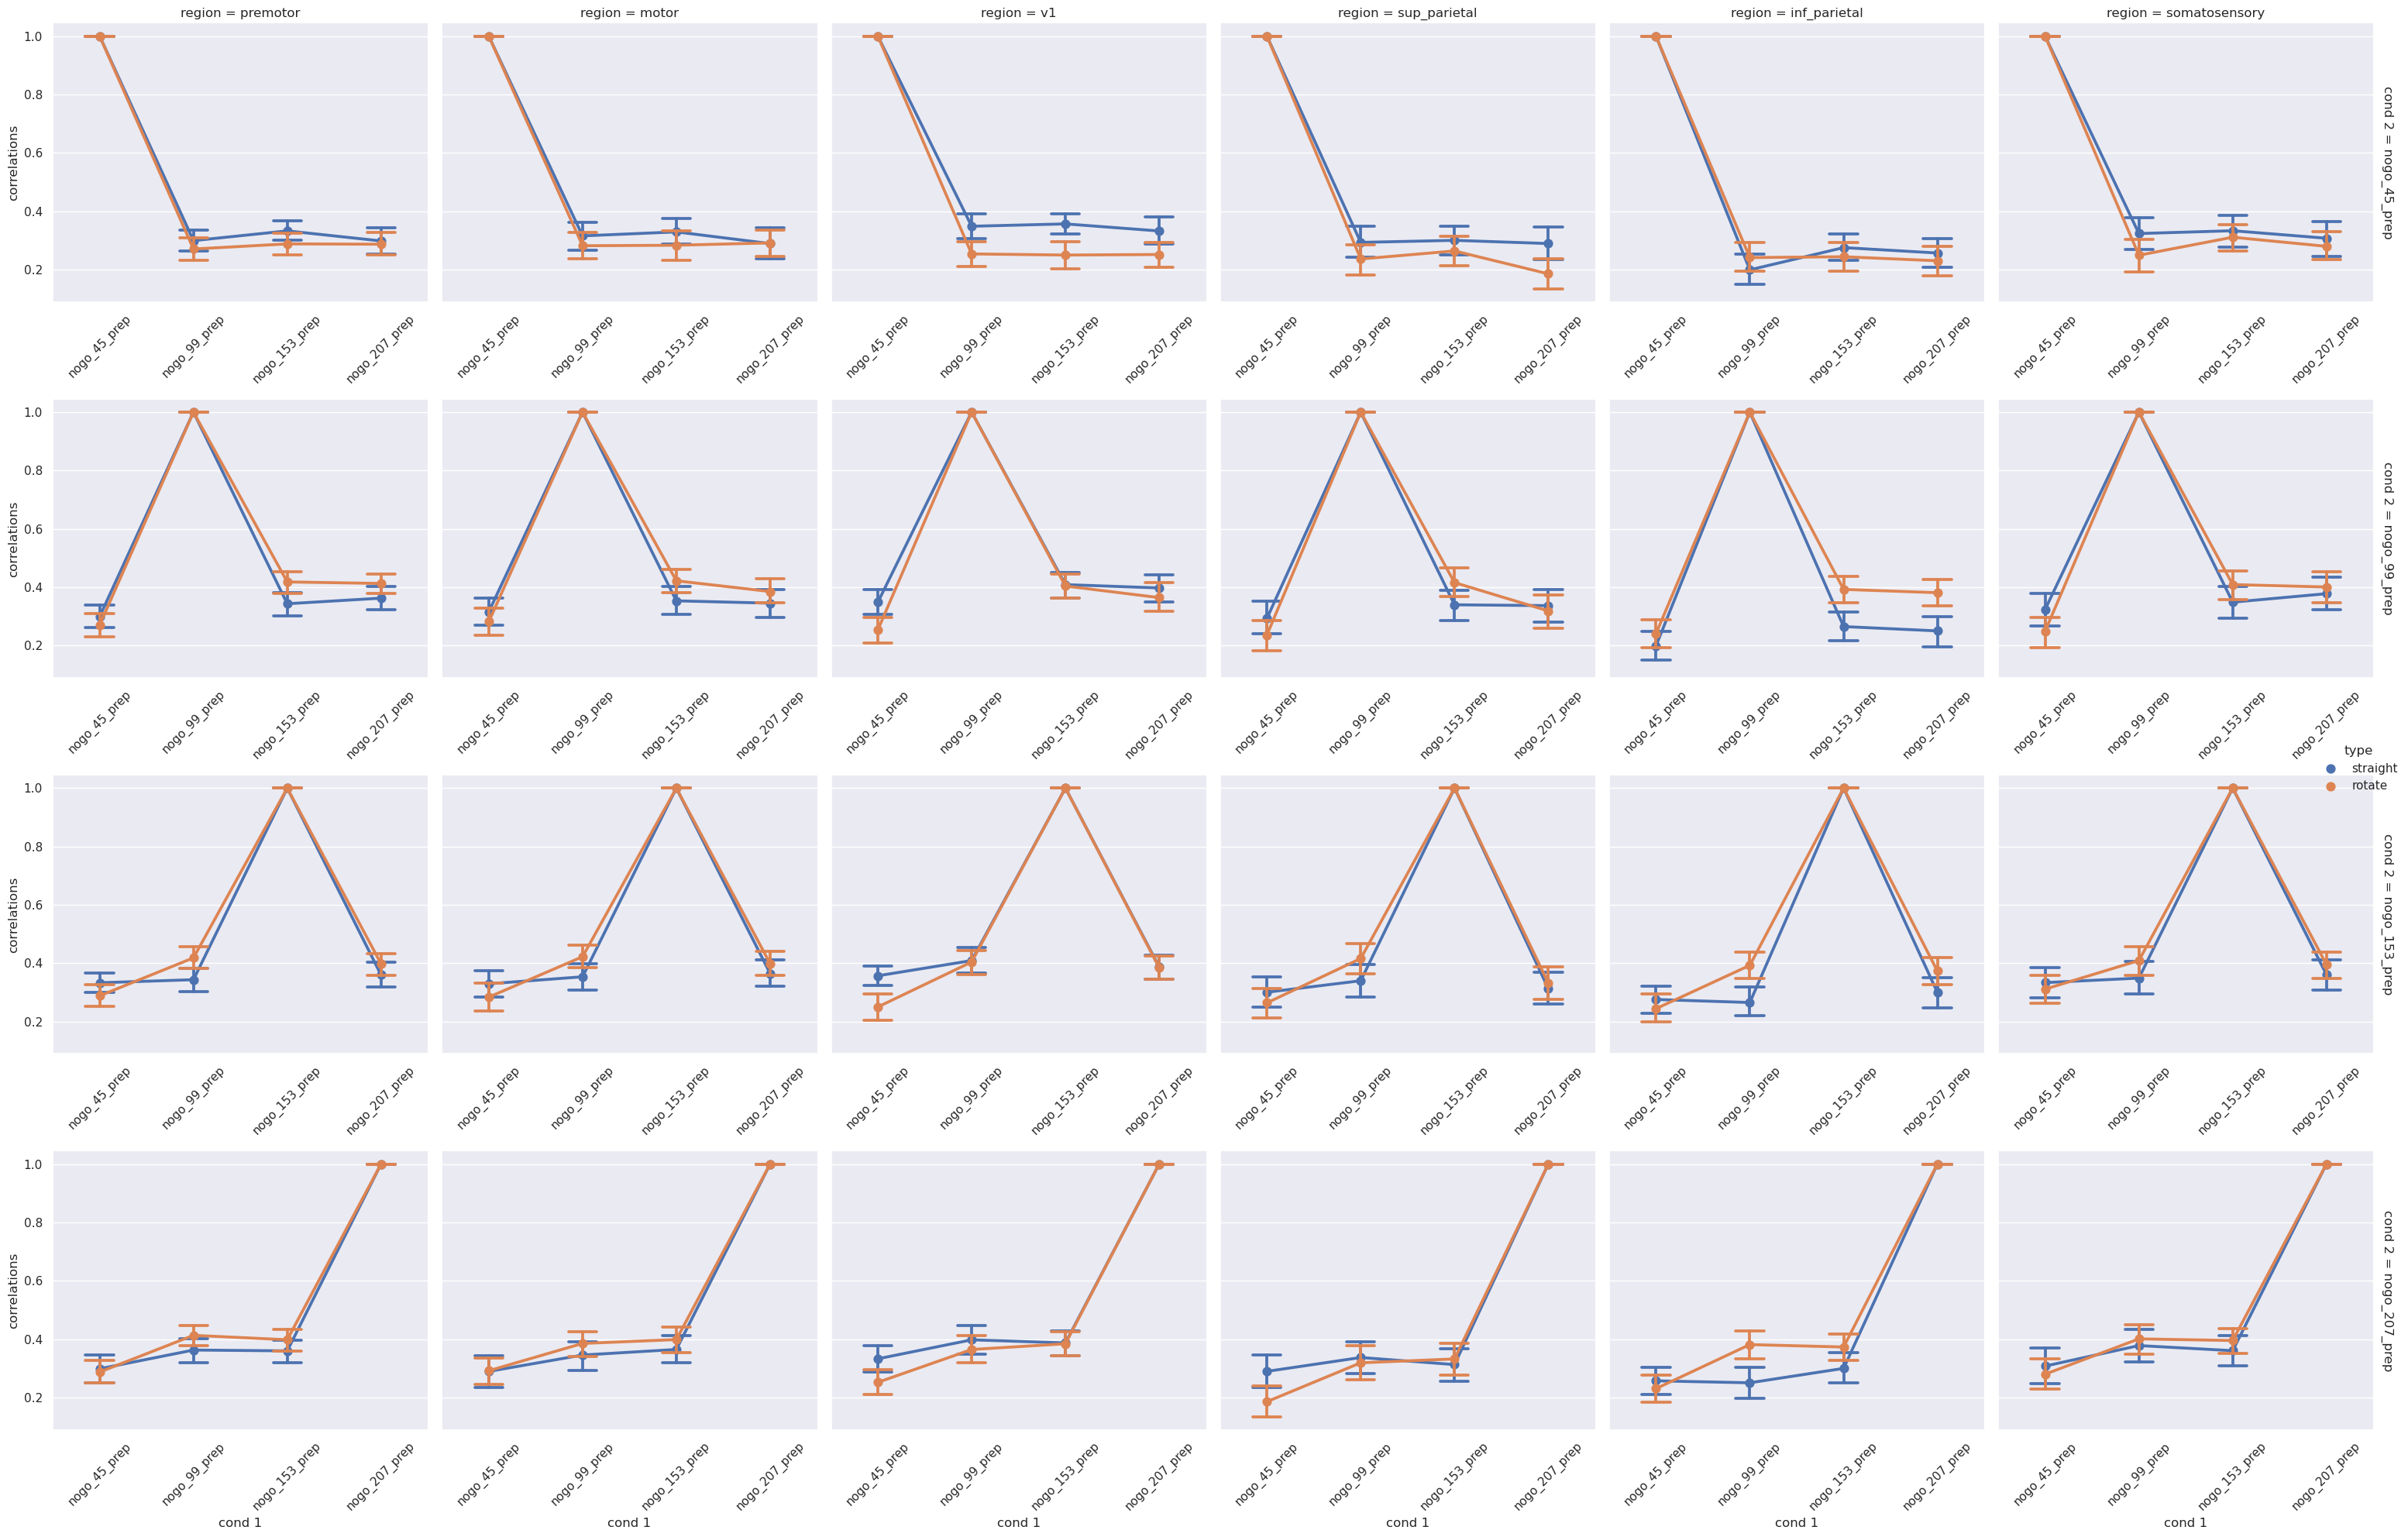

In [8]:
corr_df = pd.read_csv('mvpa_outputs/event_correlations.csv').drop('Unnamed: 0', axis = 1)
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', hue = 'type', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True, sharex = False,
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('nogo')) & (corr_df['cond 2'].str.startswith('nogo')))],
)
g.set_xticklabels(rotation=45)
plt.tight_layout()

plt.savefig('mvpa_outputs/plots/nogo_correlations.png', dpi = 600)